In [148]:
import quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample

In [149]:
pd.set_option('display.max_rows', 10000)

# Preprocesamiento

In [150]:

mydata=quandl.get(["MULTPL/SHILLER_PE_RATIO_MONTH"\
                    ,"MULTPL/SP500_REAL_PRICE_MONTH",\
                    "MULTPL/SP500_DIV_YIELD_MONTH",
                  "USTREASURY/YIELD"],\
                     authtoken="jXzqHEmopssr9P9jayeC")
df=mydata.copy()

df=df.reset_index()

df['YearMonth'] = df['Date'].map(lambda x: 100*x.year + x.month)


In [151]:
df =df.groupby(['YearMonth']).mean()[['MULTPL/SHILLER_PE_RATIO_MONTH - Value',
       'MULTPL/SP500_REAL_PRICE_MONTH - Value',
       'MULTPL/SP500_DIV_YIELD_MONTH - Value', 'USTREASURY/YIELD - 3 MO','USTREASURY/YIELD - 5 YR']]

In [152]:
pre= df.dropna()

In [153]:
mydata2=pre.copy()

# Medias de largo plazo

In [154]:
mydata_means=mydata.reset_index()

In [155]:
shiller_long_run=mydata_means[(mydata_means['Date']<='1990-01-01') & (mydata_means['Date']> '1930-01-01')]['MULTPL/SHILLER_PE_RATIO_MONTH - Value'].dropna().mean()

In [156]:
print(shiller_long_run)

14.33411111111111


In [157]:
divyield_long_run=mydata_means[(mydata_means['Date']<='1990-01-01') & (mydata_means['Date']> '1930-01-01')]['MULTPL/SP500_DIV_YIELD_MONTH - Value'].dropna().mean()

In [158]:
print(divyield_long_run)

4.5725694444444445


# Graficas

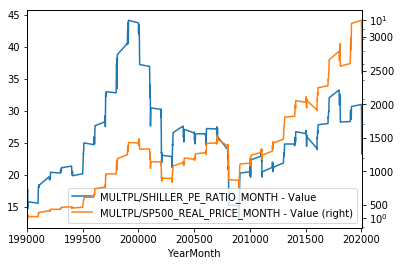

In [159]:
ax = mydata2[['MULTPL/SHILLER_PE_RATIO_MONTH - Value',
       'MULTPL/SP500_REAL_PRICE_MONTH - Value']].plot(secondary_y='MULTPL/SP500_REAL_PRICE_MONTH - Value')
ax2 = ax.twinx()
ax2.set_yscale('log')
plt.show()

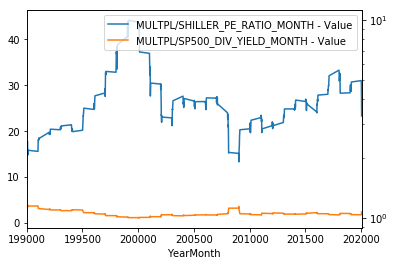

In [160]:
ax = mydata2[['MULTPL/SHILLER_PE_RATIO_MONTH - Value',
       'MULTPL/SP500_DIV_YIELD_MONTH - Value']].plot(secondary_y='MULTPL/SP500_REAL_PRICE_MONTH - Value')
ax2 = ax.twinx()
ax2.set_yscale('log')
plt.show()

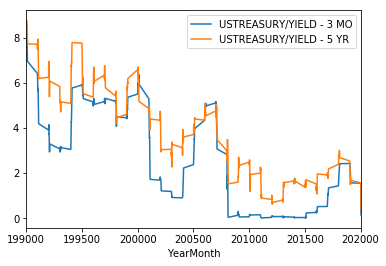

In [209]:
mydata2[['USTREASURY/YIELD - 3 MO',
       'USTREASURY/YIELD - 5 YR']].plot()
plt.show()

In [207]:
mydata2.columns

Index(['MULTPL/SHILLER_PE_RATIO_MONTH - Value',
       'MULTPL/SP500_REAL_PRICE_MONTH - Value',
       'MULTPL/SP500_DIV_YIELD_MONTH - Value', 'USTREASURY/YIELD - 3 MO',
       'USTREASURY/YIELD - 5 YR'],
      dtype='object')

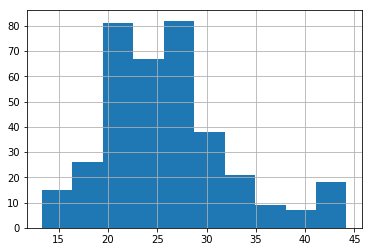

In [162]:
mydata2['MULTPL/SHILLER_PE_RATIO_MONTH - Value'].hist()

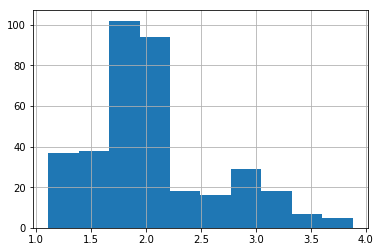

In [163]:
mydata2['MULTPL/SP500_DIV_YIELD_MONTH - Value'].hist()

# Variables

In [171]:
data=mydata2.copy()

data['spf']=data['MULTPL/SP500_REAL_PRICE_MONTH - Value'].shift(periods=-36) #36 meses hacia adelante
data['per_var']=data['spf']/data['MULTPL/SP500_REAL_PRICE_MONTH - Value']-1 # Retorno acumulado 36 meses

In [173]:
data=data.rename(columns={"MULTPL/SHILLER_PE_RATIO_MONTH - Value": "shiller_ratio"})
data['shiller_mean_adj']=data['shiller_ratio']-shiller_long_run
data=data.rename(columns={"MULTPL/SP500_DIV_YIELD_MONTH - Value": "div_yield"})
data['div_mean_adj']=data['div_yield']-divyield_long_run
data['rate_spread'] = data['USTREASURY/YIELD - 5 YR'] - data['USTREASURY/YIELD - 3 MO']

# Definicion de bueno malo

Se trabaja con una definición de rendimiento de 12% anual para el bueno malo , para 3 años sería 36%

In [175]:
data['id'] = data['per_var'].apply(lambda x: 1 if x > 0.36 else (0 if x<0 else 2)) #Definimos indeterminados si el rendimiento acumulado esta en entre 0 y 60%

In [177]:
pre_data=data.copy()

In [179]:
data = data[data['id']!= 2 ]
data.dropna(inplace=True)
data.head()

c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,shiller_ratio,MULTPL/SP500_REAL_PRICE_MONTH - Value,div_yield,USTREASURY/YIELD - 3 MO,USTREASURY/YIELD - 5 YR,spf,per_var,shiller_mean_adj,div_mean_adj,rate_spread,id
YearMonth,,,,,,,,,,,
199008,16.17,330.75,3.56,7.694348,8.436522,454.13,0.373031,1.835889,-1.012569,0.742174,1
199009,15.30,315.41,3.75,7.597895,8.513684,459.24,0.456010,0.965889,-0.822569,0.915789,1
199010,14.82,307.12,3.88,7.400000,8.327727,463.90,0.510485,0.485889,-0.692569,0.927727,1
199011,15.19,315.29,3.81,7.290500,8.022500,462.89,0.468140,0.855889,-0.762569,0.732000,1
199012,15.85,328.75,3.68,6.949500,7.726500,465.95,0.417338,1.515889,-0.892569,0.777000,1


# Train Test split 

In [183]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(data,test_size=0.3,random_state=123)
print(len(train))
print(len(test))

146
63


# Oversampling

In [184]:
train['id'].value_counts()

1    92
0    54
Name: id, dtype: int64

In [185]:
train['id'].value_counts()

# Separate majority and minority classes
train_majority = train[train.id==1]
train_minority = train[train.id==0]

print(len(train_majority))
print(len(train_minority))
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
print(train_upsampled.id.value_counts())



92
54
1    92
0    92
Name: id, dtype: int64


# Multicolinalidad

In [186]:
train_upsampled[['id','shiller_mean_adj','div_mean_adj','rate_spread']].corr()

,id,shiller_mean_adj,div_mean_adj,rate_spread
id,1.000000,-0.611036,0.653429,0.633684
shiller_mean_adj,-0.611036,1.000000,-0.859089,-0.424168
div_mean_adj,0.653429,-0.859089,1.000000,0.503332
rate_spread,0.633684,-0.424168,0.503332,1.000000


# Modelos

In [187]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from claudia import ks,gini

# Regresion Logistica

In [188]:
''' ROC '''

def evaluacion():
    print('-----------------------------------------Test  -------------------------------------')
    print(gini(test['id'],y_pred,plot=True)) # Test
    print(ks(test['id'],y_pred)) #Test

In [189]:
data.columns

Index(['shiller_ratio', 'MULTPL/SP500_REAL_PRICE_MONTH - Value', 'div_yield',
       'USTREASURY/YIELD - 3 MO', 'USTREASURY/YIELD - 5 YR', 'spf', 'per_var',
       'shiller_mean_adj', 'div_mean_adj', 'rate_spread', 'id'],
      dtype='object')

In [190]:
train_upsampled=sm.add_constant(train_upsampled)
test=sm.add_constant(test)

#Logistic Regression

#mod = smf.logit(formula='id ~  shiller_mean_adj + div_mean_adj + rate_spread  ', data=train_upsampled)
mod = smf.logit(formula='id ~ shiller_mean_adj ', data=train_upsampled)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.460653
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     id   No. Observations:                  184
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.3354
Time:                        10:45:56   Log-Likelihood:                -84.760
converged:                       True   LL-Null:                       -127.54
                                        LLR p-value:                 2.250e-20
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.2483      0.517      6.287      0.000       2.236       4.261
shiller_mea

c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [191]:
train_upsampled=sm.add_constant(train_upsampled)
test=sm.add_constant(test)

#Logistic Regression

#mod = smf.logit(formula='id ~  shiller_mean_adj + div_mean_adj + rate_spread  ', data=train_upsampled)
mod = smf.logit(formula='id ~ rate_spread + shiller_mean_adj ', data=train_upsampled)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.324815
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     id   No. Observations:                  184
Model:                          Logit   Df Residuals:                      181
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Apr 2020   Pseudo R-squ.:                  0.5314
Time:                        10:46:04   Log-Likelihood:                -59.766
converged:                       True   LL-Null:                       -127.54
                                        LLR p-value:                 3.686e-30
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8009      0.642      1.248      0.212      -0.457       2.058
rate_spread

In [192]:
y_pred=res.predict(test)

-----------------------------------------Test  -------------------------------------


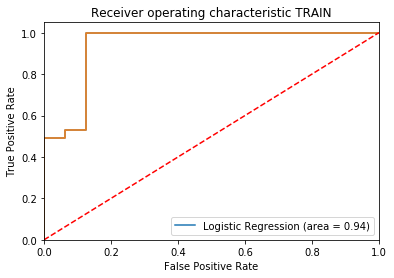

(0.9388297872340425, 0.8776595744680851)
Ks_2sampResult(statistic=0.875, pvalue=4.467246970488171e-09)


In [193]:
evaluacion()

# Random Forest

In [133]:

clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)


clf.fit(train_upsampled[['const','rate_spread','shiller_mean_adj']], train_upsampled['id'])  

y_pred=clf.predict_proba(test[['const','rate_spread','shiller_mean_adj']])

y_pred=y_pred[:,1]

-----------------------------------------Test  -------------------------------------


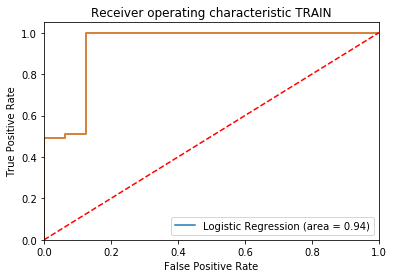

(0.9375, 0.875)
Ks_2sampResult(statistic=0.875, pvalue=4.467246970488171e-09)


In [134]:
evaluacion()

# Matriz de confusion

In [194]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

    0   1
0  14   2
1   0  47
0.9682539682539683


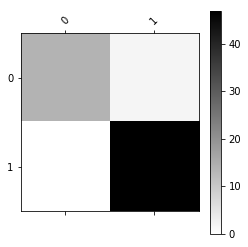

In [195]:
from sklearn.metrics import confusion_matrix

test['pred']=y_pred
test['threshold']=y_pred
test['threshold']=test['threshold'].apply(lambda x: 1 if x > 0.50 else 0)

confusion=pd.DataFrame(confusion_matrix(test['id'], test['threshold']))
print(confusion)

plot_confusion_matrix(confusion)

accuracy=(confusion.iloc[0,0]+confusion.iloc[1,1])/len(test)
print(accuracy)

# Segmentando

In [200]:

# Aplicamos sobre toda la data limpia

pre_pred=res.predict(pre_data)

#pre_data=sm.add_constant(pre_data)
#pre_pred=clf.predict_proba(pre_data[['const','mean']])[:,1]

pre_data['pred']=pre_pred

col_names = {'count_nonzero': 'tasamalos', 'size': 'obs'}



pre_data['bucket'] = pd.qcut(pre_data['pred'], 10 ,\
         duplicates='drop',retbins=True)[0]

seg=pre_data.groupby('bucket')['id']\
.agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names)

seg2=pre_data.groupby('bucket')['per_var']\
.agg([np.mean,np.var])


def q1(x):
    return x.quantile(0.01)

def q2(x):
    return x.quantile(0.99)

f = {'number': [q1,q2]}

segg=pre_data.groupby('bucket')['per_var'].agg(f)

seg2.columns=['ren_pro','var_pro']
segg.columns=['VaR','-VaR']

seg3=seg.join(seg2[['ren_pro','var_pro']])
seg3=seg3.join(segg)

seg3['inverse_dispersion_index']=seg3['ren_pro']/seg3['var_pro']

seg3['R/Var']=seg3['ren_pro']/seg3['VaR']

seg3

c:\users\jair\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


,mean,tasamalos,obs,ren_pro,var_pro,VaR,-VaR,inverse_dispersion_index,R/Var
bucket,,,,,,,,,
"(0.00229, 0.0661]",0.540541,10,37,-0.183833,0.022228,-0.406142,0.111094,-8.270416,0.452634
"(0.0661, 0.229]",0.861111,17,36,-0.133611,0.071127,-0.410413,0.447372,-1.878488,0.325553
"(0.229, 0.421]",1.166667,25,36,0.186164,0.271654,-0.340745,1.015149,0.685297,-0.546344
"(0.421, 0.707]",1.135135,30,37,0.430088,0.167032,-0.169525,1.102951,2.574881,-2.537014
"(0.707, 0.838]",1.472222,36,36,0.424963,0.055925,0.069952,1.041722,7.598747,6.075043
"(0.838, 0.908]",1.444444,35,36,0.480876,0.109431,0.007061,1.187594,4.394313,68.106415
"(0.908, 0.953]",1.486486,34,37,0.308553,0.022620,-0.064678,0.526831,13.640661,-4.770624
"(0.953, 0.986]",1.388889,34,36,0.374843,0.059136,-0.038537,1.105511,6.338640,-9.726737
"(0.986, 0.995]",1.444444,36,36,0.412233,0.061551,0.039685,1.073306,6.697443,10.387618


In [227]:
pre_data.tail(3)

,shiller_ratio,MULTPL/SP500_REAL_PRICE_MONTH - Value,div_yield,USTREASURY/YIELD - 3 MO,USTREASURY/YIELD - 5 YR,spf,per_var,shiller_mean_adj,div_mean_adj,rate_spread,id,pred,bucket
YearMonth,,,,,,,,,,,,,
202002,29.54,3116.060,1.885,1.544737,1.323684,NaN,NaN,15.205889,-2.687569,-0.221053,2,0.058079,"(0.00229, 0.0661]"
202003,23.91,2532.615,2.400,0.295455,0.591818,NaN,NaN,9.575889,-2.172569,0.296364,2,0.405263,"(0.229, 0.421]"
202004,23.32,2470.500,2.410,0.145882,0.391176,NaN,NaN,8.985889,-2.162569,0.245294,2,0.403348,"(0.229, 0.421]"


# Histograma Bucket

In [205]:
def bucket_view(minimo, maximo):
    bucket_actual=pre_data[(pre_data.pred  >= minimo) & (pre_data.pred <= maximo)]
    
    print('Probability of loss :',len(bucket_actual[bucket_actual.per_var <= 0])/ len(bucket_actual))
    #bucket_actual.hist()
    
    bucket_actual.per_var.hist()
    plt.axvline(x=0, color = 'r')


Probability of loss : 0.3055555555555556


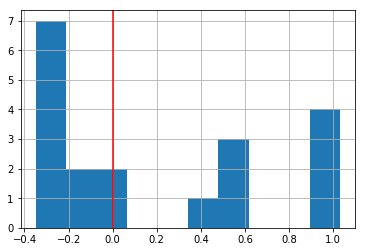

In [206]:
bucket_view(0.229,0.421)

# Predicción Especifica

In [258]:
pre_data.tail(1)

,shiller_ratio,MULTPL/SP500_REAL_PRICE_MONTH - Value,div_yield,USTREASURY/YIELD - 3 MO,USTREASURY/YIELD - 5 YR,spf,per_var,shiller_mean_adj,div_mean_adj,rate_spread,id,pred,bucket
YearMonth,,,,,,,,,,,,,
202004,23.32,2470.5,2.41,0.145882,0.391176,NaN,NaN,8.985889,-2.162569,0.245294,2,0.403348,"(0.229, 0.421]"


In [248]:
revision=mydata['USTREASURY/YIELD - 5 YR']-mydata['USTREASURY/YIELD - 3 MO']
revision.tail(1)

Date
2020-04-24    0.24
dtype: float64

In [249]:
val= test.tail(1).copy()

In [250]:
val = val.reset_index()

In [259]:
val['rate_spread'] = 0.24
#val['shiller_mean_adj'] = 26.92-14.33
val['shiller_mean_adj'] = 8.98

In [260]:
val

,YearMonth,const,shiller_ratio,MULTPL/SP500_REAL_PRICE_MONTH - Value,div_yield,USTREASURY/YIELD - 3 MO,USTREASURY/YIELD - 5 YR,spf,per_var,shiller_mean_adj,div_mean_adj,rate_spread,id,pred,threshold
0,200705,1.0,27.55,1511.14,1.72,4.867727,4.667273,1125.06,-0.255489,8.98,-2.852569,0.24,0,0.088086,0


In [261]:
res.predict(val)

0    0.400492
dtype: float64

# Pre Analisis

In [271]:
pre_data.columns

Index(['shiller_ratio', 'MULTPL/SP500_REAL_PRICE_MONTH - Value', 'div_yield',
       'USTREASURY/YIELD - 3 MO', 'USTREASURY/YIELD - 5 YR', 'spf', 'per_var',
       'shiller_mean_adj', 'div_mean_adj', 'rate_spread', 'id', 'pred',
       'bucket'],
      dtype='object')

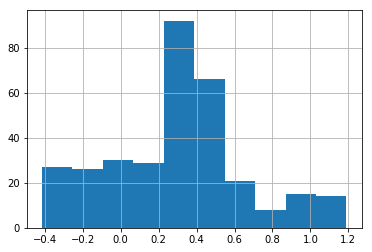

In [278]:
pre_data['per_var'].hist()

22


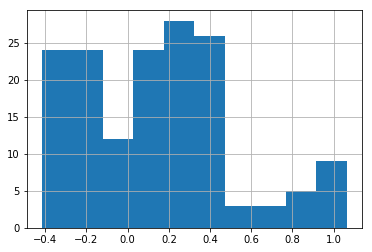

In [276]:
pre_data[pre_data.shiller_ratio>25 ]['per_var'].hist()
print(len(pre_data[pre_data.shiller_mean_adj>25 ]))

342


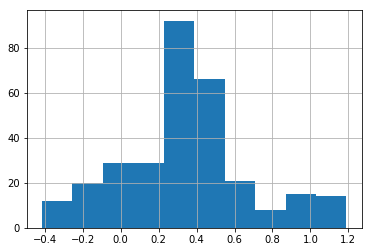

In [277]:
pre_data[pre_data.shiller_mean_adj<=25 ]['per_var'].hist()
print(len(pre_data[pre_data.shiller_mean_adj<=25 ]))

In [267]:
len(pre_data)

364